# Solution using `FEniCSx` and an external tagged mesh

In this case we want to follow a geometry-agnostic approach. We define the mesh using `gmsh` in the notebook [create-interval-mesh.ipynb](./create-interval-mesh.ipynb) instead of doing it using `FEniCSx`.

In [1]:
from dolfinx import default_scalar_type, fem, mesh
from dolfinx.fem.petsc import LinearProblem, assemble_matrix, assemble_vector, apply_lifting, set_bc
from dolfinx.io import gmshio
import gmsh
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import ufl

## Load previously generated mesh

We load the mesh previously generated.

In [2]:
Omega, cell_tags, facet_tags = gmshio.read_from_msh("interval.msh", MPI.COMM_WORLD)

Info    : Reading 'interval.msh'...
Info    : 5 entities
Info    : 101 nodes
Info    : 102 elements
Info    : Done reading 'interval.msh'


`Omega` is the interval mesh.

In [3]:
Omega

We can extract the mesh nodes from the geometry of `Omega`.

In [4]:
I = Omega.geometry.x[:,0]
I

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

`material_tags` contains all the tags defined in the mesh.

In [5]:
material_tags = np.unique(cell_tags.values)
material_tags

array([1, 2], dtype=int32)

## Function space, boundary conditions

We procees as in [fenics-simple.ipynb](../fenics-simple/fenics-simple.ipynb).

In [6]:
V = fem.functionspace(Omega, ("Lagrange", 1))
V0 = fem.functionspace(Omega, ("DG", 0))

u = ufl.TrialFunction(V)
phi = ufl.TestFunction(V)

dofs_L = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
dofs_R = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1))
bc_L = fem.dirichletbc(default_scalar_type(0), dofs_L, V)
bc_R = fem.dirichletbc(default_scalar_type(10), dofs_R, V)
bcs = [bc_L, bc_R]

## Defining parameters on tags

In [7]:
sigma = fem.Function(V0)
sigma_list = {
    1: 1,  # tag 1: value on subdomain 1
    2: 2,  # tag 2: value on subdomain 2
}
for tag in material_tags:
    cells = cell_tags.find(tag)
    sigma.x.array[cells] = np.full_like(cells, sigma_list[tag], dtype=default_scalar_type)

## Solve differential problem

In [8]:
lhs = ufl.inner(sigma * ufl.grad(u), ufl.grad(phi)) * ufl.dx
rhs = fem.Constant(Omega, default_scalar_type(0)) * phi * ufl.dx

In [9]:
problem = LinearProblem(lhs, rhs, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u = problem.solve()

In [10]:
u

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, interval, 1, equispaced, unset, False, float64, []), (3,)), 0), Basix element (P, interval, 1, gll_warped, unset, False, float64, [])), 1)

## Comparison with analytic solution

In [11]:
y = fem.Function(V)
I = Omega.geometry.x[:,0]
y.x.array[:] = np.where(I < 0.5, I * 40 / 3, I * 20 / 3 + 10 / 3)
L2_error = fem.assemble_scalar(fem.form(ufl.inner(u - y, u - y) * ufl.dx))
L2_error

3.7047448648904e-26

## Matrix generation

We show how to obtain the arrays associated to the weak linear problem. `FEniCSx` can apply the Dirichlet boundary conditions on the matrix `A` and on the array `b`, so that the solution `x` of `Ax=b` has the Dirichlet conditions enforced on the corresponding indices.

In [12]:
a = fem.form(lhs)
A = assemble_matrix(a, bcs=bcs)
A.assemble()

In [13]:
from scipy.sparse import csr_matrix
csr = csr_matrix(A.getValuesCSR()[::-1], shape=A.size)
print(csr.toarray())

[[   1.    0.    0. ...    0.    0.    0.]
 [   0.  200. -100. ...    0.    0.    0.]
 [   0. -100.  200. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...  400. -200.    0.]
 [   0.    0.    0. ... -200.  400.    0.]
 [   0.    0.    0. ...    0.    0.    1.]]


In [14]:
b = assemble_vector(fem.form(rhs))
apply_lifting(b, [fem.form(a)], [bcs])
set_bc(b, bcs)
b.array

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       2000.,   10.])

## Plotting

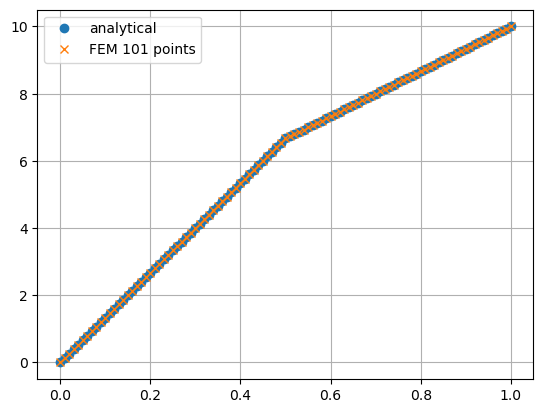

In [15]:
plt.plot(I, y.x.array, "o", label="analytical")
plt.plot(I, u.x.array, "x", label="FEM 101 points")
plt.legend()
plt.grid()
plt.show()

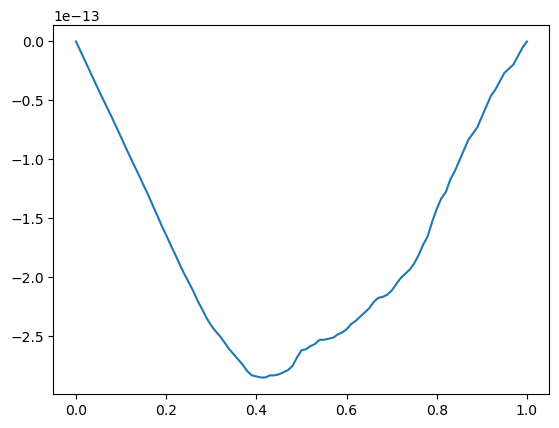

In [16]:
plt.plot(I, y.x.array - u.x.array)